In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
"make_results/10_folds_results/fold_0_blr/batch_1/Z_estimate.txt"
"make_results/10_folds_results/fold_0_SHASHb/batch_1/MCMC_zscores/MCMC_zscores_0_SHASHb_fold0.pkl"

'make_results/10_folds_results/fold_0_SHASHb/batch_1/MCMC_zscores/MCMC_zscores_0_SHASHb_fold0.pkl'

In [3]:
all_zscores = {}
# For each feature
features = ['Right-Cerebellum-White-Matter',
            'EstimatedTotalIntraCranialVol',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem']
for fold in range(10):
    for iff, feature in enumerate(features):
        for l in ['SHASHo','SHASHb','Normal']:
            with open(f"10_folds_results/fold_{fold}_{l}_sexcov/batch_{iff+1}/MCMC_zscores/MCMC_zscores_{iff}_{l}_fold{fold}_sexcov.pkl",'rb') as file:
                all_zscores[(fold, iff, l)] = pickle.load(file)
        all_zscores[(fold, iff, 'blr')] = np.loadtxt(f"10_folds_results/fold_{fold}_blr_sexcov/batch_{iff+1}/Z_estimate.txt")

In [4]:
foldclasses = {}
unique_classes = []
for fold in range(10):
    with open(f"/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_{fold}/Z_test.pkl",'rb') as file:
        foldclasses[fold] = pickle.load(file)
        unique_classes = np.unique(foldclasses[fold]['site_id'].to_numpy())
        

In [ ]:
all_aucs = {}
for iff, feature in enumerate(features):
    for fold in range(10):
        for l in ['SHASHo','SHASHb','Normal','blr']:
            print(f'{fold}, {l}, {feature}')
            aucs = np.zeros((len(unique_classes), len(unique_classes)))
            for i, v in enumerate(unique_classes):
                for j in range(i):
                    if i != j:
                        full_zscores = all_zscores[(fold, iff, l)]
                        classes = foldclasses[fold]
                        
#                         print(classes.shape, full_zscores.shape)
                        idxs = np.where(((classes['site_id'] == i) | (classes['site_id'] == j)))
#                         print(np.max(idxs) > full_zscores.shape[0])
#                             idxs = np.where((classes['sex'] == sex) & ((classes['site_id'] == i) | (classes['site_id'] == j)))

                        selected_zscores = full_zscores[idxs[0]]
                        selected_classes = classes.iloc[idxs[0]]['site_id'].to_numpy()

                        auc = roc_auc_score(selected_classes, selected_zscores)
                        aucs[i,j] = auc
                        aucs[j,i] = auc
            all_aucs[(iff, fold, l)] = aucs
            s = plt.imshow(aucs, vmin = 0, vmax = 1)
#             plt.colorbar(s)
#             plt.title(f'fold {fold}, {l}, feature={feature}')
#             plt.savefig(f'/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/AUC_images/fold{fold}-l{l}-feature={feature}.png',dpi=300)
#             plt.show()

#             plt.close()

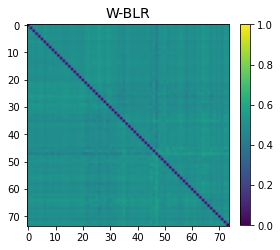

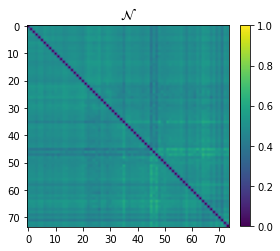

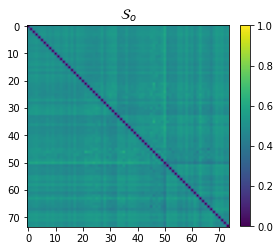

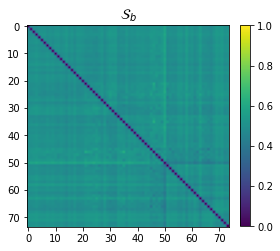

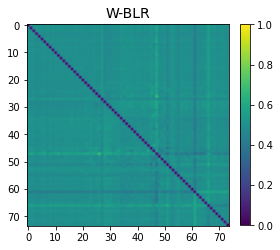

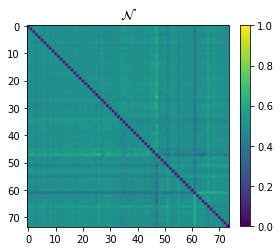

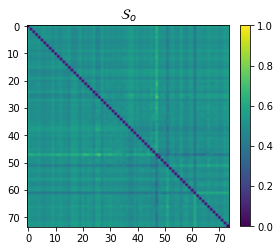

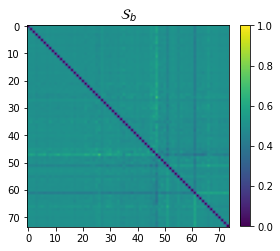

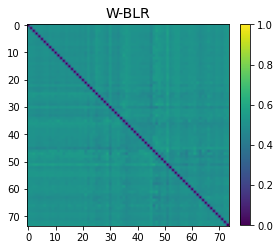

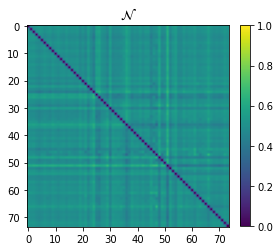

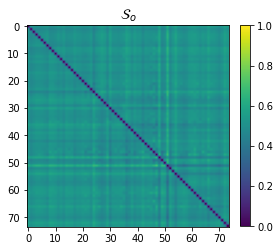

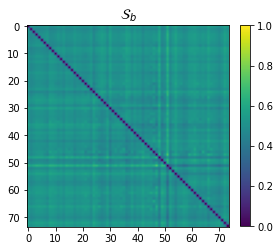

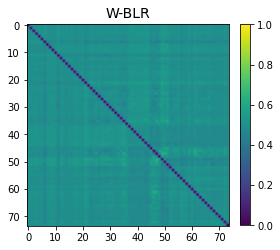

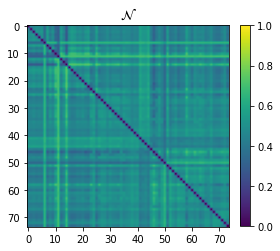

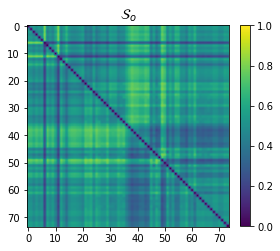

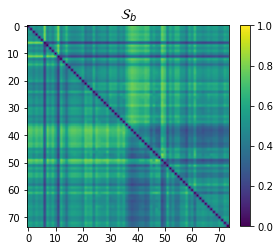

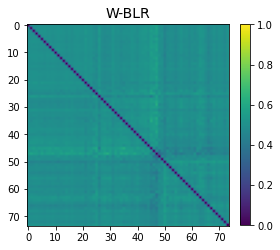

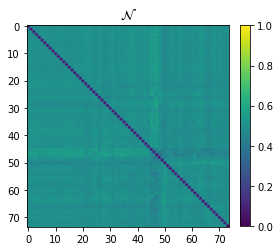

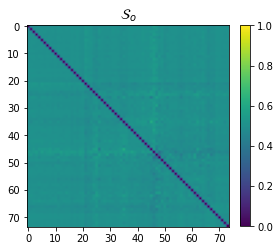

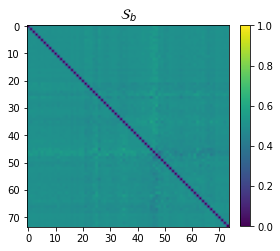

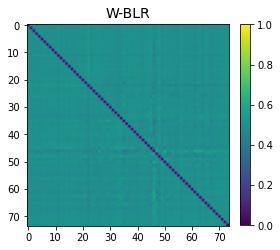

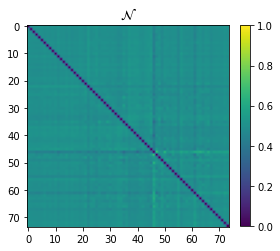

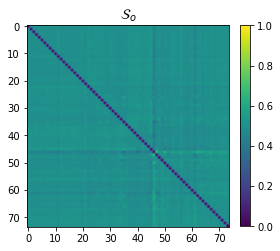

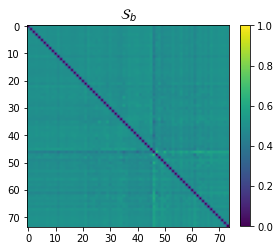

In [51]:
def make_AUC_plot(feature, l, ylabel=False, colorbar=False):
    lmap = {'blr':'W-BLR','SHASHo':'$\mathcal{S}_o$', 'SHASHb':'$\mathcal{S}_b$', 'Normal':'$\mathcal{N}$'}
    iff = features.index(feature)
    this_auc = np.zeros_like(all_aucs[( iff, 0, l)])
    for fold in range(10):
        this_auc += all_aucs[(iff,fold,l)]
    this_auc = this_auc/10
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    c = ax.imshow(this_auc, vmin = 0, vmax=1)
    cbar = fig.colorbar(c, fraction=0.045, pad=0.05)
    lx = this_auc.shape[0]
    ticks = [i*10 for i in range((lx//10)+1)]
    
    plt.yticks(ticks)
    plt.xticks(ticks)
    plt.title(lmap[l], fontsize=14)
    plt.savefig(f'/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/AUC_images/{feature}_{l}.png',bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

for feature in features:
    for il, l in enumerate(['blr','Normal','SHASHo','SHASHb']):
        make_AUC_plot(feature, l)

In [ ]:
# plt.colorbar(vmin=0,vmax=1)

In [9]:
dumpfile = os.path.join('auc_dir')
if not os.path.exists(dumpfile):
    os.mkdir(dumpfile)
with open(os.path.join(dumpfile,'naive_aucs'),'wb') as file:
    pickle.dump(all_aucs, file)

In [4]:
dumpfile = os.path.join('auc_dir')
if not os.path.exists(dumpfile):
    os.mkdir(dumpfile)
with open(os.path.join(dumpfile,'naive_aucs'),'rb') as file:
    all_aucs = pickle.load(file)